This notebook is to train a Variational Autoencoder on Model Parameters dataset, but align the latent variables with the angle of the corresponding model.

In [6]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModel, VAE

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

import math


In [7]:
def eight_normal_sample(centers, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(2), math.sqrt(var) * torch.eye(2)
    )
    n = centers.shape[0]
    centers = centers * scale
    noise = m.sample((n,)).to(centers.device)
    data = []
    for i in range(n):
        data.append(centers[i] + noise[i])
    data = torch.stack(data)
    return data

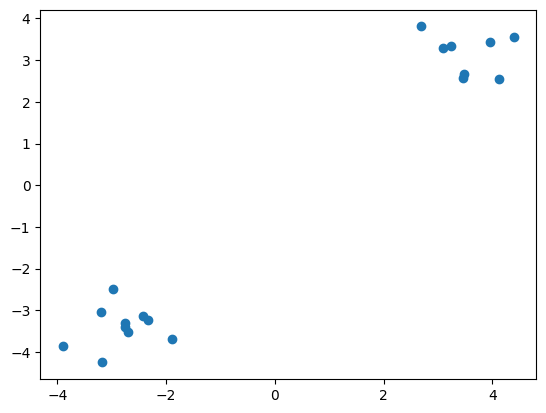

In [8]:
centers = torch.tensor([[1, 1], [1, 1],[1, 1],[1, 1],[1, 1],[1, 1],[1, 1],[1, 1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1], [-1,-1]])
r = eight_normal_sample(centers, scale=3, var=0.1)
plt.scatter(r[:, 0], r[:, 1])

In [ ]:
# Hyperparameters
epochs = 100
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
dropout = 0.2

torch.manual_seed(random_seed)

# Model
autoencoder = VAE(latent_dim, dropout)
model = DBModel()

autoencoder.to(device)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/vae_dbloss_aligned"
model_path = "{}/model_aligned_kdl{}.pth".format(path, kdl_weight)

In [10]:
def loss_fn(x, x_hat, mean, log_var, kdl_weight=40):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kdl_weight*KLD

## Train

In [11]:
autoencoder.train()
losses = []
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        angles_batch = angles_batch.to(device)

        angles_batch = angles_batch * math.pi / 180
        sin = torch.sin(angles_batch)
        cos = torch.cos(angles_batch)
        centers = torch.stack([cos, sin], dim=1)
        aligned_centers = eight_normal_sample(centers, scale=3, var=0.1).to(device)

        encoded = autoencoder.encoder(parameters_batch)

        means = autoencoder.mu(encoded)
        logvars = autoencoder.logvar(encoded)
        latent = autoencoder.reparameterize(means, logvars)

        reconstructed = autoencoder.decoder(latent)
        
        # reconstructed, mean, logvar = autoencoder(parameters_batch)
        output = model(reconstructed, input)

        # Ground truth
        goal = model(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(goal, output, means, logvars, kdl_weight)
        means_loss = nn.functional.mse_loss(latent, aligned_centers)
        loss += (means_loss * 1e5)
        loss.backward()
        total_loss += loss.item()
    
        optimizer.step()
    
    if(epoch % 10 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/model_aligned_kdl{kdl_weight}_epoch{epoch}.pth")
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    losses.append(total_loss)

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - Loss: 514398693.375
Epoch 1 - Loss: 273122423.375
Epoch 2 - Loss: 212607189.53125
Epoch 3 - Loss: 199077208.515625
Epoch 4 - Loss: 175911212.875
Epoch 5 - Loss: 161563858.109375
Epoch 6 - Loss: 159369418.6875
Epoch 7 - Loss: 149619177.703125
Epoch 8 - Loss: 144589926.84375
Epoch 9 - Loss: 143896840.625
Epoch 10 - Loss: 159930270.65625
Epoch 11 - Loss: 140210372.8125
Epoch 12 - Loss: 134316948.984375
Epoch 13 - Loss: 134463085.828125
Epoch 14 - Loss: 132650204.59375
Epoch 15 - Loss: 126662552.75
Epoch 16 - Loss: 124085795.25
Epoch 17 - Loss: 123381376.671875
Epoch 18 - Loss: 122635719.25
Epoch 19 - Loss: 124158085.390625
Epoch 20 - Loss: 121403145.203125
Epoch 21 - Loss: 121416952.578125
Epoch 22 - Loss: 120633776.875
Epoch 23 - Loss: 120923453.53125
Epoch 24 - Loss: 119855201.421875
Epoch 25 - Loss: 119912937.4375
Epoch 26 - Loss: 120707008.109375
Epoch 27 - Loss: 119346348.421875
Epoch 28 - Loss: 118859985.234375
Epoch 29 - Loss: 119344388.984375
Epoch 30 - Loss: 117972139.9

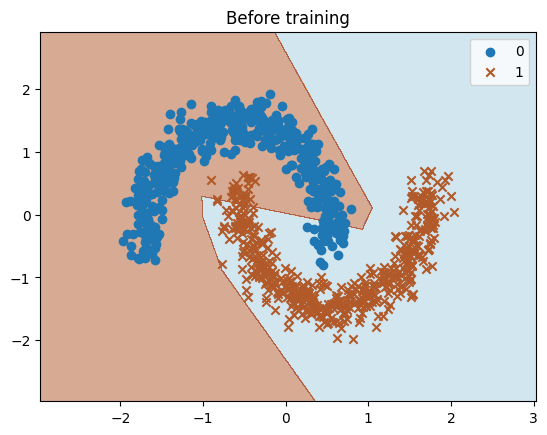

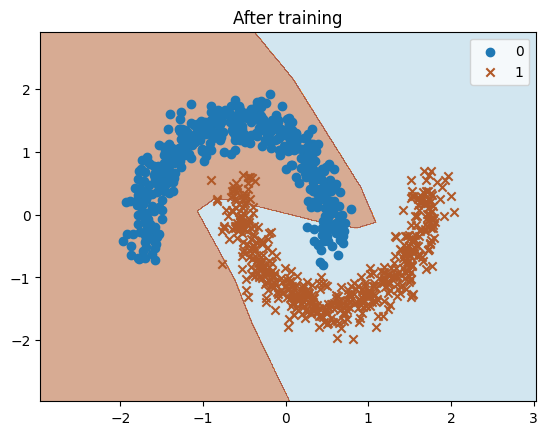

In [12]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 12250
sample = eight_normal_sample(torch.tensor([[1, 1]]), scale=3, var=0.1)

parameters = dataset[index][0]
reconstructed, _, _ = autoencoder(parameters.unsqueeze(0))
reconstructed = reconstructed.squeeze()
X, y = get_moons_dataset()
plot_decision_boundary(parameters, X, y, title="Before training")
plot_decision_boundary(reconstructed, X, y, title="After training")

## Latent Space

(80000, 2)


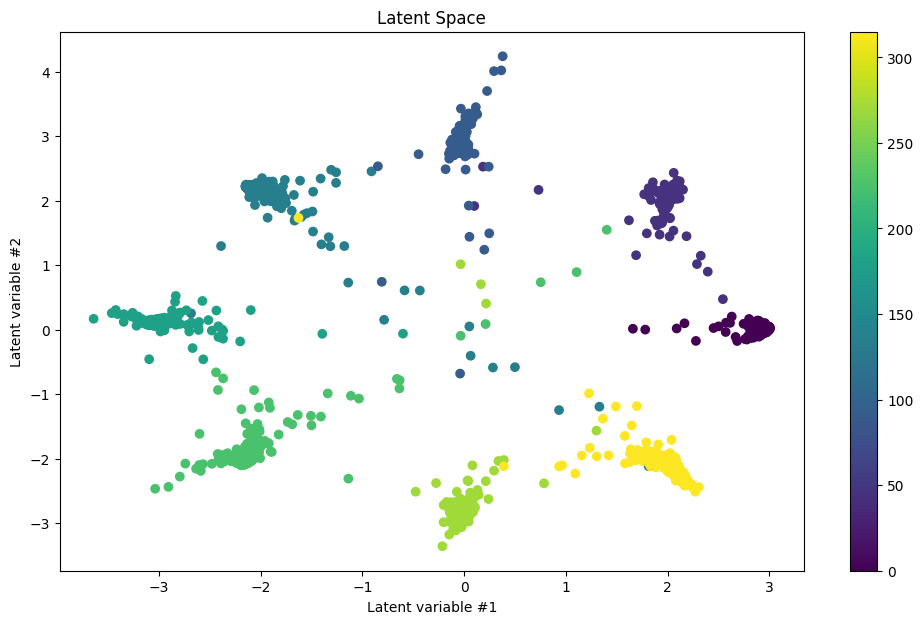

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

raw_unseen = pd.read_csv("../data/extra_angles.csv")
weights_unseen = raw_unseen.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles_unseen = raw_unseen["angle"].to_numpy()

# # Join both weights
# weights = np.vstack([weights, weights_unseen])
# angles = np.hstack([angles, angles_unseen])

weights = torch.tensor(weights).float()
latent, mean, logvar = autoencoder(weights)
latent = autoencoder.reparameterize(mean, logvar).detach().numpy()
latent = mean.detach().numpy()
print(latent.shape)

fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(latent[:, 0], latent[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')


plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weights distribution

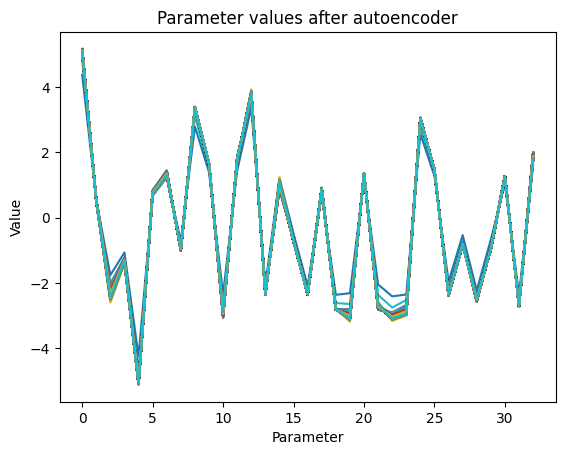

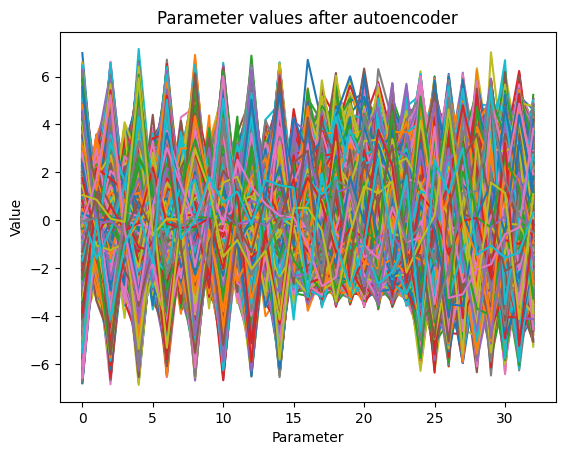

In [ ]:
from matplotlib import pyplot as plt

model = VAE(latent_dim, dropout)
model.load_state_dict(torch.load(model_path))
model.eval()

orignial = []
reconstruction = []
for i in range(10000):
    parameters = dataset[i][0].unsqueeze(0)
    r, _, _ = model(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)
    orignial.append(parameters.squeeze().detach().numpy())


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()
plt.close()

for r in orignial:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values before autoencoder")
plt.show()
plt.close()

## Accuracy distribution

  0%|          | 0/16000 [00:00<?, ?it/s]

Mean trained accuracy: 99.8715
Mean reconstructed accuracy: 99.66598125000002


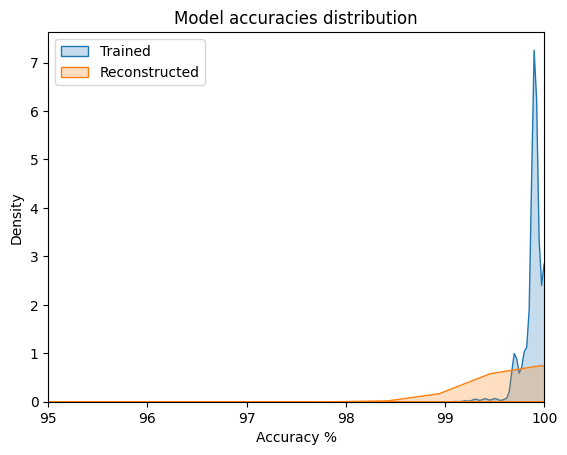

In [ ]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(test_dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed, _, _ = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(95, 100)
plt.show()


## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 97.76811000000002


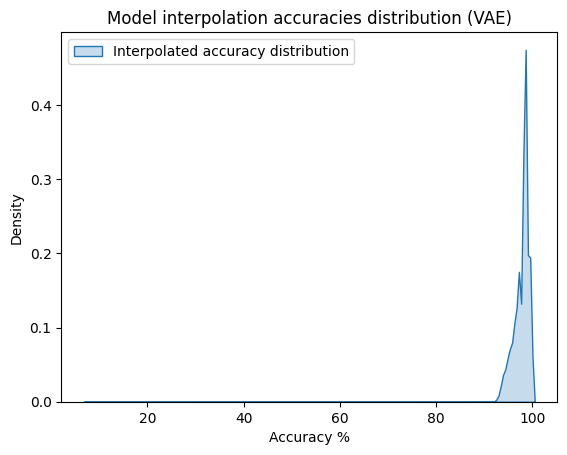

In [ ]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        mean_1 = autoencoder.mu(latent_1)
        logvar_1 = autoencoder.logvar(latent_1)
        latent_1 = autoencoder.reparameterize(mean_1, logvar_1)

        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        mean_2 = autoencoder.mu(latent_2)
        logvar_2 = autoencoder.logvar(latent_2)
        latent_2 = autoencoder.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 96.68657714285716


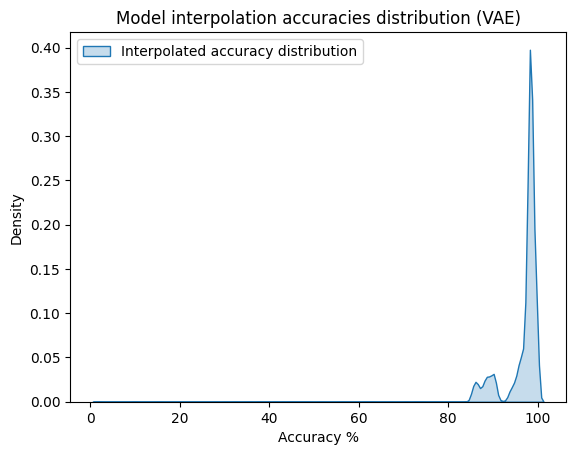

In [ ]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
bad_accuracy = []

for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))

        mean_1 = autoencoder.mu(latent_1)
        logvar_1 = autoencoder.logvar(latent_1)
        latent_1 = autoencoder.reparameterize(mean_1, logvar_1)

        mean_2 = autoencoder.mu(latent_2)
        logvar_2 = autoencoder.logvar(latent_2)
        latent_2 = autoencoder.reparameterize(mean_2, logvar_2)

        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy(w, X_rotated, y)
        # if(accuracy < 50):
        #     print(i)
        #     print(i+1)
        #     print(j)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model interpolation accuracies distribution (VAE)")
plt.xlabel("Accuracy %")
plt.show()

In [ ]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    mean_1 = model.mu(latent_1)
    logvar_1 = model.logvar(latent_1)
    latent_1 = model.reparameterize(mean_1, logvar_1)

    latent_2 = model.encoder(parameters_2)
    mean_2 = model.mu(latent_2)
    logvar_2 = model.logvar(latent_2)
    latent_2 = model.reparameterize(mean_2, logvar_2)

    angle_diff = angle_2 - angle_1
    # latent = np.sin((1-alpha)*angle_diff*np.pi/90)/np.sin(angle_diff*np.pi/90)*latent_1 + np.sin(alpha*angle_diff*np.pi/90)/np.sin(angle_diff*np.pi/90)*latent_2
    latent = (1-alpha)*latent_1 + alpha*latent_2

    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y, title=f"{angle:.2f}°")

In [ ]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 2
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>

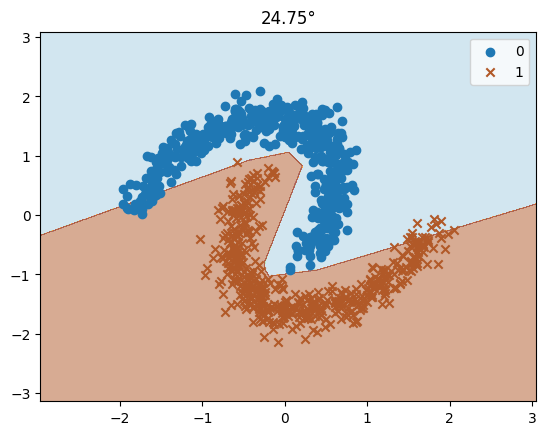

In [ ]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.55
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

plot_interpolation(autoencoder, datapoint_1, datapoint_2, X, y, alpha)

## See samples accuracy

In [ ]:
dataset = ModelParamsDataset("../data/eight_angles_small.csv")

vae = VAE(2)
vae.load_state_dict(torch.load(model_path))
vae.eval()
sample = dataset[0][0].unsqueeze(0)

X, y = get_moons_dataset()
X = torch.tensor(X).float()

accuracies = []

with torch.inference_mode():
    for i in range(1000):
        reconstructed, _, _ = vae(sample)
        reconstructed = reconstructed.squeeze()
        accuracy = get_accuracy(reconstructed, X, y)
        accuracies.append(accuracy)

print(f"Mean accuracy: {np.mean(accuracies)}")

Mean accuracy: 99.85620000000002


## Sample

In [14]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 12250
angle = 72
X, y = get_moons_dataset()

def slider(angle):
    X_rotated = rotate(X, angle)
    angle = torch.tensor([angle * math.pi / 180])
    sin = torch.sin(angle)
    cos = torch.cos(angle)
    center = torch.stack([cos, sin], dim=1)
    sample = eight_normal_sample(center, scale=3, var=0.1)
    reconstructed = autoencoder.decoder(sample).squeeze()
    plot_decision_boundary(reconstructed, X_rotated, y, title="After training")

interact(slider, angle=widgets.IntSlider(min=0, max=360, step=1, value=0))

interactive(children=(IntSlider(value=0, description='angle', max=360), Output()), _dom_classes=('widget-inter…

<function __main__.slider(angle)>

In [116]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

accuracies = []
angles = [0, 45, 90, 135, 180, 225, 270, 315]

with torch.no_grad():
    for angle in tqdm(angles):
    
        for i in tqdm(range(1000)):
            X, y = get_moons_dataset()
            X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
            a = torch.tensor([angle * math.pi / 180])
            sin = torch.sin(a)
            cos = torch.cos(a)
            center = torch.stack([cos, sin], dim=1)
            sample = eight_normal_sample(center, scale=3, var=0.1)
            reconstructed = autoencoder.decoder(sample).squeeze()
            accuracy = get_accuracy(reconstructed, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 98.8154


<Axes: ylabel='Density'>

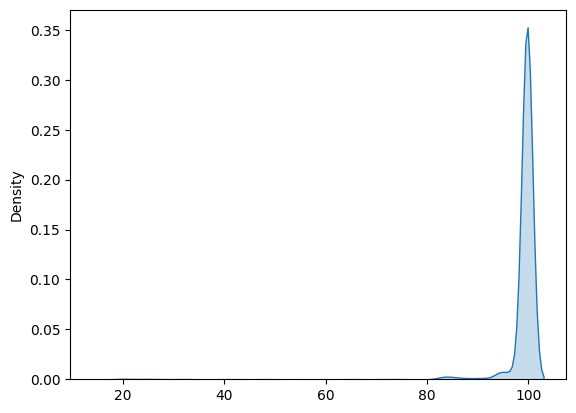

In [117]:
sns.kdeplot(accuracies, fill=True)


In [118]:
autoencoder = VAE(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

accuracies = []
angles = [45/2, 135/2, 225/2, 315/2, 405/2, 495/2, 585/2, 675/2]

with torch.no_grad():
    for angle in tqdm(angles):
    
        for i in tqdm(range(1000)):
            X, y = get_moons_dataset()
            X_rotated = torch.tensor(rotate(X, angle), dtype=torch.float32)
            a = torch.tensor([angle * math.pi / 180])
            sin = torch.sin(a)
            cos = torch.cos(a)
            center = torch.stack([cos, sin], dim=1)
            sample = eight_normal_sample(center, scale=3, var=0.1)
            reconstructed = autoencoder.decoder(sample).squeeze()
            accuracy = get_accuracy(reconstructed, X_rotated, y)
            accuracies.append(accuracy)
    

print("Mean accuracy:", np.mean(accuracies))

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Mean accuracy: 96.91671249999999


<Axes: ylabel='Density'>

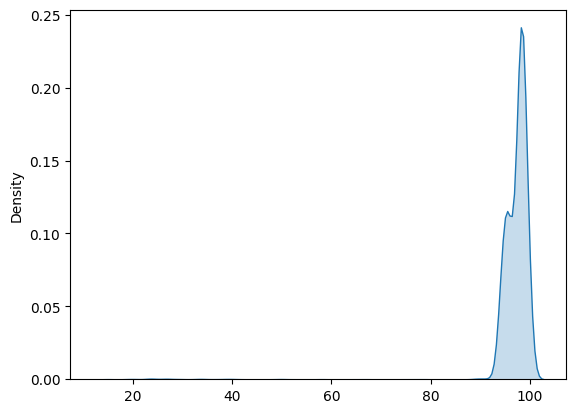

In [119]:
sns.kdeplot(accuracies, fill=True)
